In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from statsmodels.stats.proportion import proportion_confint

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [2]:
# Define article restrictions
journals_keep = ['Nat Commun', 'PLoS One', 'PLoS Comput Biol', 'Proc Natl Acad Sci U S A',
                 'eLife', 'J Neurosci', 'Front Hum Neurosci', 'Front Neurosci',
                 'F1000Res', 'J Neurophysiol', 'Nature', 'Neuroimage', 'Neuron', 'Science',
                 'Brain', 'eNeuro', 'Neuroscience', 'Front Syst Neurosci',
                 'Nat Neurosci', 'Nat Methods']
cols_keep = ['Journal Title', 'Year', 'PMCID', 'PMID']
year_min = 2014

In [3]:
# Load database of available articles
df = pd.read_csv('/gh/data/opencode/PMC-ids.csv')

df_keep = df[(df['Journal Title'].isin(journals_keep)) &
             (df['Year'] >= year_min)
             ]
df_keep = df_keep[cols_keep]

# Remove articles without a PMID (not read)
df_keep.dropna(subset=['PMID'], inplace=True)
df_keep = df_keep.reset_index(drop=True)

/Users/scott/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
len(df_keep)

173979

In [5]:
pd.DataFrame(df_keep['Journal Title'].value_counts())

,Journal Title
PLoS One,111946
Proc Natl Acad Sci U S A,17131
Nat Commun,14580
eLife,4880
Front Hum Neurosci,3347
J Neurosci,3320
Front Neurosci,2708
PLoS Comput Biol,2690
F1000Res,2121
J Neurophysiol,1834


In [6]:
# Load data from June 29 scrape
# terms = ['python', 'matlab', 'public', 'open', 'code', 'source', 'github']
# other = ['aff', 'subject']
N_articles = 147359
N_chunk = 10000
file_nums = np.append(np.arange(N_chunk, N_articles, N_chunk), N_articles)
terms = ['python', 'matlab', 'github']
other = []

# Remove Nat Methods articles from first scrape because in 2nd
ids_rmv = df_keep[df_keep['Journal Title']=='Nat Methods']['PMCID'].values

dfs = defaultdict(list)
for k in terms + other:
    for fi_num in file_nums:
        csv_name = '/gh/data2/opencode/june29/{:s}_{:d}.csv'.format(k, fi_num)
        dfs[k].append(pd.read_csv(csv_name, index_col=0))
    dfs[k] = pd.concat(dfs[k])
    
    dfs[k] = dfs[k][~dfs[k]['PMCID'].isin(ids_rmv)]
    
# Append data from July 18 scrape
N_articles = 27026
for k in terms + other:
    csv_name = '/gh/data2/opencode/july18/{:s}_{:d}.csv'.format(k, N_articles)
    df_temp = pd.read_csv(csv_name, index_col=0)
    dfs[k] = pd.concat([dfs[k], df_temp])

# Only keep articles with MATLAB or python

In [7]:
ids_mat = dfs['matlab']['PMCID'].unique()
ids_py = dfs['python']['PMCID'].unique()
ids_code = np.union1d(ids_mat, ids_py)
dfs_code = {}
for k in dfs.keys():
    dfs_code[k] = dfs[k][dfs[k]['PMCID'].isin(ids_code)]
    
df_articles = df_keep[df_keep['PMCID'].isin(ids_code)].reset_index(drop=True)

In [8]:
df_articles['Journal Title'].value_counts()

PLoS One                    8154
Nat Commun                  2234
eLife                       1407
Front Hum Neurosci          1029
PLoS Comput Biol            1002
Front Neurosci               673
Nature                       313
eNeuro                       250
Neuroimage                   207
Nat Neurosci                 194
Front Syst Neurosci          163
F1000Res                     143
Nat Methods                  106
Proc Natl Acad Sci U S A      95
J Neurosci                    72
Neuron                        63
Brain                         56
J Neurophysiol                46
Neuroscience                  10
Name: Journal Title, dtype: int64

### Plot fraction of articles in MATLAB and python for each journal
* Don't plot PNAS because of definite underestimate due to supplementary methods

In [9]:
# Determine if each article contains matlab or python
matlab_ids = dfs_code['matlab']['PMCID'].unique()
df_keep['is_matlab'] = df_keep['PMCID'].isin(matlab_ids)

python_ids = dfs_code['python']['PMCID'].unique()
df_keep['is_python'] = df_keep['PMCID'].isin(python_ids)
df_keep['is_both'] = df_keep['is_matlab'] & df_keep['is_python']

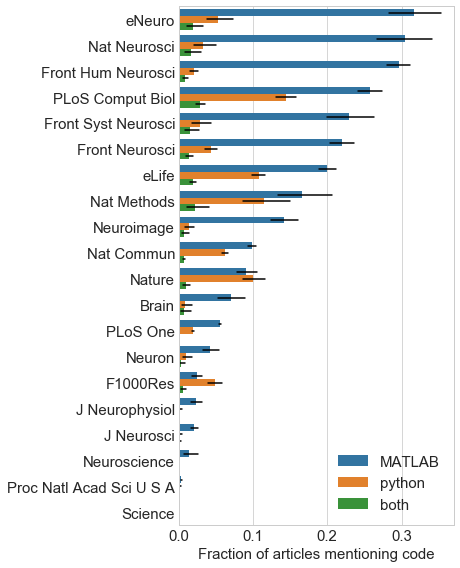

In [10]:
# Format df for plotting bars of proportions
df_bars = df_keep.groupby('Journal Title')[['is_matlab', 'is_python', 'is_both']].mean()
df_plt = df_bars.stack().reset_index().rename(columns={'level_1':'code', 0:'frac'})
df_plt.replace({'is_matlab': 'MATLAB', 'is_python': 'python', 'is_both': 'both'}, inplace=True)
order = df_plt[df_plt['code']=='MATLAB'].sort_values(by='frac', ascending=False)['Journal Title'].values

# Plot bars
plt.figure(figsize=(6.5,8))
sns.barplot(x='frac', y='Journal Title', hue='code', data=df_plt, order=order)
plt.xlabel('Fraction of articles mentioning code', size=15)
plt.legend(title='', fontsize=15)
plt.ylabel('')
plt.yticks(size=15)
plt.xticks(np.arange(0,.4,.1), size=15)

# Make errorbars
for i, journal in enumerate(order):
    for j, code in enumerate(['is_matlab', 'is_python', 'is_both']):
        x = df_keep[df_keep['Journal Title']==journal][code]
        if x.sum() > 1:
            conf_int = proportion_confint(x.sum(), len(x), method = 'binom_test')
        else:
            conf_int = (x.mean(), x.mean())
        plt.plot(conf_int, [i+.25*(j-1),i+.25*(j-1)], 'k-')
        
plt.tight_layout()
plt.savefig('figs/code_mentions.png')

# Fraction of articles sharing code

In [11]:
# Determine if each article contains matlab or python
github_ids = dfs_code['github']['PMCID'].unique()
df_articles['has_github'] = df_articles['PMCID'].isin(github_ids)
df_articles['has_matlab'] = df_articles['PMCID'].isin(dfs_code['matlab']['PMCID'].unique())
df_articles['has_python'] = df_articles['PMCID'].isin(dfs_code['python']['PMCID'].unique())

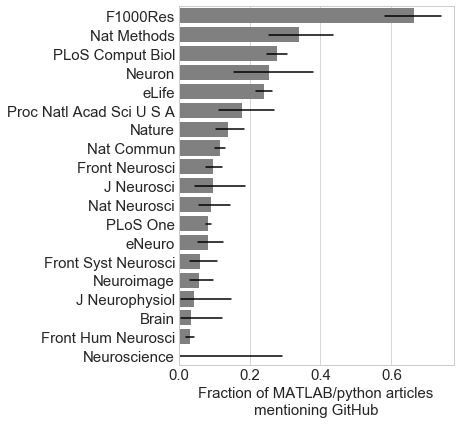

In [12]:
# Format df for plotting bars of proportions
df_plt = pd.DataFrame(df_articles.groupby('Journal Title')['has_github'].mean()).reset_index()
order = df_plt.sort_values('has_github', ascending=False)['Journal Title'].values

# Plot bars
plt.figure(figsize=(6.5,6))
sns.barplot(x='has_github', y='Journal Title', data=df_plt, color='0.5', order=order)
plt.xlabel('Fraction of MATLAB/python articles\nmentioning GitHub', size=15)
plt.ylabel('')
plt.yticks(size=15)
plt.xticks(np.arange(0,1.1,.2), size=15)

# Make errorbars
for i, journal in enumerate(order):
    x = df_articles[df_articles['Journal Title']==journal]['has_github']
    conf_int = proportion_confint(x.sum(), len(x), method = 'binom_test')
    plt.plot(conf_int, [i,i], 'k-')
        
plt.tight_layout()
plt.savefig('figs/github_mentions.png')

# Estimate the fraction of articles sharing code
* Based on manual labeling (Notebook 4), the 'github' search term underestimates sharing by 1/3

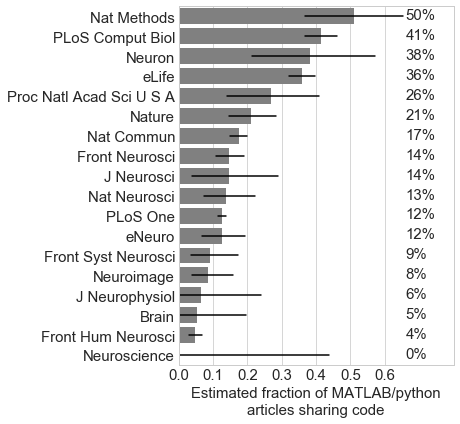

In [13]:
# Format df for plotting bars of proportions
df_plt['shares'] = df_plt['has_github']*1.5
df_plt = df_plt[df_plt['Journal Title'] != 'F1000Res']
order = df_plt.sort_values('shares', ascending=False)['Journal Title'].values

# Plot bars
plt.figure(figsize=(6.5,6))
sns.barplot(x='shares', y='Journal Title', data=df_plt, color='0.5', order=order)
plt.xlabel('Estimated fraction of MATLAB/python\narticles sharing code', size=15)
plt.ylabel('')
plt.yticks(size=15)
plt.xticks(np.arange(0,.7,.1), size=15)
plt.xlim((0,.8))

# Make errorbars
for i, journal in enumerate(order):
    x = 1.5*df_articles[df_articles['Journal Title']==journal]['has_github']
    conf_int = proportion_confint(x.sum(), len(x), method = 'binom_test')
    m = x.mean()
    conf_int = (m - 1.5*(m-conf_int[0]), m + 1.5*(conf_int[1]-m))
    plt.plot(conf_int, [i,i], 'k-')
    
# Annotations
for i, journal in enumerate(order):
    pc = int(100*1.5*df_articles[df_articles['Journal Title']==journal]['has_github'].mean())
    plt.text(.66, i+.15, '{:d}%'.format(pc), fontsize=15)
        
plt.tight_layout()
plt.savefig('figs/sharing_estimates.png')

# Compare sharing in matlab vs python

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


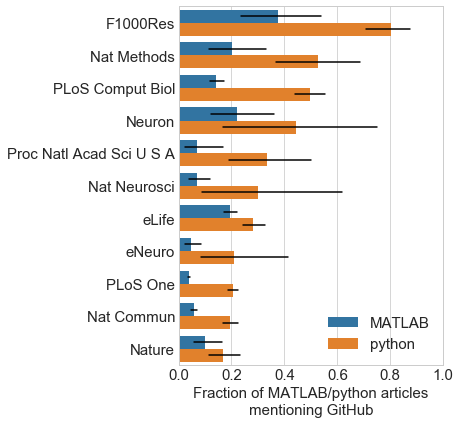

In [14]:
# Format df for comparing matlab and python
df_articles['has_xor'] = np.logical_xor(df_articles['has_matlab'], df_articles['has_python'])
df_vs = df_articles[df_articles['has_xor']]
df_vs['lang'] = df_vs['has_matlab'].map({True:'MATLAB', False:'python'})

# Format df for plotting bars of proportions
df_plt = df_vs.groupby(['Journal Title', 'lang'])['has_github'].mean().reset_index()
df_plt = df_plt[df_plt['Journal Title'].isin(['Nat Commun', 'PLoS One', 'PLoS Comput Biol', 'Proc Natl Acad Sci U S A',
                                              'eLife', 'F1000Res', 'Nature', 'Neuron', 'eNeuro',
                                              'Nat Neurosci', 'Nat Methods'])]
order = df_plt[df_plt['lang']=='python'].sort_values('has_github', ascending=False)['Journal Title'].values

# Plot bars
plt.figure(figsize=(6.5,6))
sns.barplot(x='has_github', y='Journal Title', hue='lang', data=df_plt, order=order)
plt.xlabel('Fraction of MATLAB/python articles\nmentioning GitHub', size=15)
plt.legend(title='', fontsize=15)
plt.ylabel('')
plt.yticks(size=15)
plt.xticks(np.arange(0,1.1,.2), size=15)
plt.xlim((0,1))

# Make errorbars
for i, journal in enumerate(order):
    for j, code in enumerate(['matlab', 'python']):
        x = df_vs[(df_vs['Journal Title']==journal) & (df_vs['has_'+code])]['has_github']
        conf_int = proportion_confint(x.sum(), len(x), method = 'binom_test')
        plt.plot(conf_int, [i+.4*(j-.5),i+.4*(j-.5)], 'k-')
        
plt.tight_layout()
plt.savefig('figs/sharing_matlab_python.png')

# Sharing over time

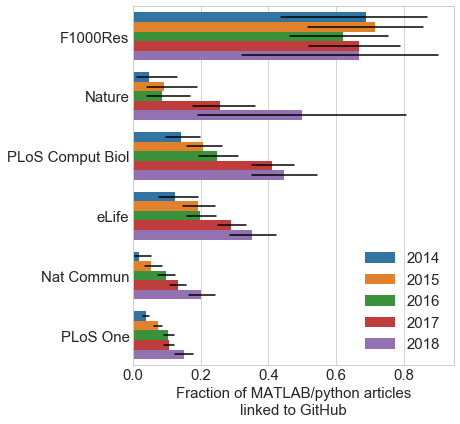

In [15]:
# Format df for plotting bars of proportions
df_plt = df_articles.groupby(['Journal Title', 'Year'])['has_github'].mean().reset_index()
df_plt = df_plt[df_plt['Journal Title'].isin(['Nat Commun', 'PLoS One', 'PLoS Comput Biol', 'eLife',
                                              'F1000Res', 'Nature'])]
order = df_plt[df_plt['Year']==2018].sort_values('has_github', ascending=False)['Journal Title'].values

# Plot bars
plt.figure(figsize=(6.5,6))
sns.barplot(x='has_github', y='Journal Title', hue='Year', data=df_plt, order=order)
plt.xlabel('Fraction of MATLAB/python articles\nlinked to GitHub', size=15)
plt.legend(title='', fontsize=15)
plt.ylabel('')
plt.yticks(size=15)
plt.xticks(np.arange(0,1.1,.2), size=15)

# Make errorbars
years = df_plt['Year'].unique()
for i, journal in enumerate(order):
    for j, year in enumerate(years):
        x = df_articles[(df_articles['Journal Title']==journal) & (df_articles['Year']==year)]['has_github']
        conf_int = proportion_confint(x.sum(), len(x), method = 'binom_test')
        plt.plot(conf_int, [i+.16*(j-2),i+.16*(j-2)], 'k-')
        
plt.tight_layout()
plt.savefig('figs/sharing_time.png')